<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
<center>
Авторы материала: Виталий Радченко (YouScan) и Юрий Кашницкий (Mail.Ru Group).

Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Домашнее задание №5
## <center> Случайный лес и логистическая регрессия в задачах кредитного скоринга и классификации отзывов к фильмам

#### Нашей главной задачей будет построение и настройка моделей для задач кредитного скоринга и анализа отзывов к фильмам. Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1s17pqYJ1kUez7F_c0qHDLYpucL5XMs9QWK4JgTfxk9E/edit).

Но для разминки решите первое задание.

**<font color='red'>Задание 1.</font>** В зале суда есть 7 присяжных, каждый из них по отдельности с вероятностью 80% может правильно определить, виновен подсудимый или нет. С какой вероятностью присяжные все вместе вынесут правильный вердикт, если решение принимается большинством голосов?

**<font color='red'>Варианты ответа:</font>**
- 20.97%
- 80.00%
- 83.70%
## - 96.66%

Теперь перейдем непосредственно к машинному обучению.

#### Данные по кредитному скорингу представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	– Человек имел долгие просрочки выплат платежей за 2 года; бинарный признак

##### Независимые признаки
* age	                         – Возраст заёмщика кредитных средств (число полных лет); тип – integer
* NumberOfTime30-59DaysPastDueNotWorse	– Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней (но не больше) в течение последних двух лет; тип -	integer
* DebtRatio –	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип – float
* MonthlyIncome	– Месячный доход в долларах; тип –	float
* NumberOfTimes90DaysLate – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип –	integer
* NumberOfTime60-89DaysPastDueNotWorse –	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней (но не больше) в течение последних двух лет; тип – integer
* NumberOfDependents – Число человек в семье кредитозаёмщика; тип –	integer

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [78]:
pd.__version__

'0.20.3'

Напишем функцию, которая будет заменять значения NaN на медиану в каждом столбце таблицы. 

In [79]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table   

Считываем данные

In [80]:
data = pd.read_csv('../../data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Рассмотрим типы считанных данных

In [81]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Посмотрим на распределение классов в зависимой переменной

Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

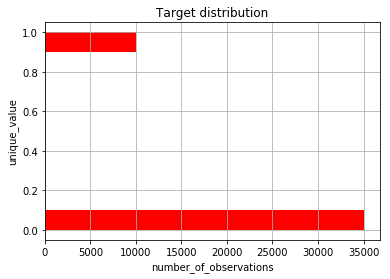

In [82]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts() / data.shape[0]

Выберем названия всех признаков, кроме прогнозируемого

In [83]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Применяем функцию, заменяющую все значения NaN на медианное значение соответствующего столбца.

In [84]:
table = impute_nan_with_median(data)

Разделяем целевой признак и все остальные – получаем обучающую выборку. 

In [85]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

Выведем версии основных библиотек – результат `GridSearchCV`, например, может отличаться в разных версиях `sklearn` даже при фиксированном `random_state`.

In [86]:
#!pip install watermark
#%load_ext watermark

In [87]:
#%watermark -v -m -p numpy,scipy,pandas,matplotlib,sklearn -g

# Бутстрэп

**<font color='red'>Задание 2.</font>** Сделайте интервальную оценку (на основе бутстрэпа) среднего дохода (MonthlyIncome) клиентов, просрочивших выплату кредита, и отдельно – для вовремя заплативших. Стройте 90% доверительный интервал. Найдите разницу между нижней границей полученного интервала для не просрочивших кредит и верхней границей – для просрочивших. 
То есть вас просят построить 90%-ые интервалы для дохода "хороших" клиентов $[good\_income\_lower, good\_income\_upper]$ и для "плохих" – $[bad\_income\_lower, bad\_income\_upper]$ и найти разницу $good\_income\_lower - bad\_income\_upper$.

Используйте пример из [статьи](https://habrahabr.ru/company/ods/blog/324402/). Поставьте `np.random.seed(17)`. Округлите ответ до целых.

**<font color='red'>Варианты ответа:</font>**
- 345
- 425
- 585
## - 655

In [88]:
def get_bootstrap_samples(data,nsamples):
    np.random.seed(17)
    indices = np.random.randint(0, len(data),(nsamples,len(data)))
    samples = data[indices]
    return samples
def intervals(stat,alpha):
                                boundaries = np.percentile(stat, [100*alpha/2.,100*(1-alpha/2.)])
                                return boundaries

In [89]:
income_no_dlq = data[data['SeriousDlqin2yrs'] == False]['MonthlyIncome'].values

In [90]:
income_w_dlq = data[data['SeriousDlqin2yrs'] == True]['MonthlyIncome'].values

In [91]:
good_income = [np.mean(sample) 
                       for sample in get_bootstrap_samples(income_no_dlq, 1000)]
bad_income = [np.mean(sample)
                        for sample in get_bootstrap_samples(income_w_dlq, 1000)]

In [92]:
print("good income:  mean interval",  intervals(good_income, 0.10))
print("bad income:  mean interval",  intervals(bad_income, 0.10))

good income:  mean interval [ 6295.93237577  6505.35467934]
bad income:  mean interval [ 5462.17301516  5641.20421404]


In [93]:
6296-5641

655

# Дерево решений, подбор гиперпараметров

Одной из основных метрик качества модели является площадь под ROC-кривой. Значения ROC-AUC лежат от 0 до 1. Чем ближе значение ROC-AUC к 1, тем качественнее происходит классификация моделью.

Найдите с помощью `GridSearchCV` гиперпараметры `DecisionTreeClassifier`, максимизирующие площадь под ROC-кривой. 

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Используем модуль `DecisionTreeClassifier` для построения дерева решений. Из-за несбалансированности классов  в целевом признаке добавляем параметр балансировки. Используем также параметр `random_state=17` для воспроизводимости результатов.

In [95]:
dt = DecisionTreeClassifier(random_state=17, class_weight='balanced')

Перебирать будем вот такие значения гиперпараметров:

In [96]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

Зафиксируем кросс-валидацию: стратифицированная, 5 разбиений с перемешиванием, не забываем про `random_state`.

In [97]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

**<font color='red'>Задание 3.</font>**
Сделайте GridSearch с метрикой ROC AUC по гиперпараметрам из словаря `tree_params`. Какое максимальное значение ROC AUC получилось (округлите до 2 знаков после разделителя)? Назовем кросс-валидацию устойчивой, если стандартное отклонение метрики качества на кросс-валидации меньше 1%. Получилась ли кросс-валидация устойчивой при оптимальных сочетаниях гиперпараметров (т.е. обеспечивающих максимум среднего значения ROC AUC на кросс-валидации)?

**<font color='red'>Варианты ответа:</font>** - 0.82, нет
- 0.84, нет
## - 0.82, да
- 0.84, да

In [98]:
tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17, class_weight='balanced'), 
                         tree_params, 
                         cv=skf, 
                         scoring='roc_auc',
                         return_train_score=True) 

In [99]:
tree_grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9], 'max_features': [4, 5, 6, 7]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [100]:
print (np.round(tree_grid.best_score_, 2))

0.82


In [101]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 6}

In [102]:
seven = tree_grid.cv_results_['std_test_score'][7]

In [103]:
seven

0.0011943384208877169

In [104]:
seven/tree_grid.best_score_ * 100

0.14559734277873648

### Простая реализация случайного леса

### **<font color='red'>Задание 4.</font>**
Реализуйте свой собственный случайный лес с помощью `DecisionTreeClassifier` с лучшими параметрами из прошлого задания. В нашем лесу будет 10 деревьев, предсказанные вероятности которых вам нужно усреднить. 

Краткая спецификация: 
 - Используйте основу ниже
 - В методе `fit` в цикле (`i` от 0 до `n_estimators-1`) фиксируйте seed, равный (`random_state + i`). Почему именно так – неважно, главное чтоб на каждой итерации seed был новый, при этом все значения можно было бы воспроизвести
 - Зафиксировав seed, выберите **без замещения** `max_features` признаков, сохраните список выбранных id признаков в `self.feat_ids_by_tree`
 - Также сделайте bootstrap-выборку (т.е. **с замещением**) из множества id объектов 
 - Обучите дерево с теми же `max_depth`, `max_features` и `random_state`, что и у `RandomForestClassifierCustom` на выборке с нужным подмножеством объектов и признаков
 - Метод `fit` возвращает текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self`
 - В методе `predict_proba` опять нужен цикл по всем деревьям. У тестовой выборки нужно взять те признаки, на которых соответсвующее дерево обучалось, и сделать прогноз вероятностей (`predict_proba` уже для дерева). Метод должен вернуть усреднение прогнозов по всем деревьям.

Проведите кросс-валидацию. Какое получилось среднее значение ROC AUC на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
## - 0.823
- 0.833
- 0.843
- 0.853

In [105]:
from sklearn.model_selection import cross_val_score

from sklearn.base import BaseEstimator

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=3, max_features=10, random_state=17):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        # в данном списке будем хранить отдельные деревья
        self.trees = []
        # тут будем хранить списки индексов признаков, на которых обучалось каждое дерево 
        self.feat_ids_by_tree = []
        
    def get_samples(self, data):
        features = np.random.choice(data.columns, self.max_features, replace=False)
        data = data[features]
        indices = list(set(np.random.randint(data.shape[0], size=data.shape[0])))
        data = data.iloc[indices,:]
        return data, features, indices
    
    def fit(self,X,y):
        for i in range(self.n_estimators):
            np.random.seed(self.random_state+i)
            self.trees.append(DecisionTreeClassifier(class_weight='balanced', random_state=self.random_state,
                                                   max_depth=self.max_depth, max_features=self.max_features))
            data, features, indices = self.get_samples(X)
            self.feat_ids_by_tree.append(features)
            self.trees[i].fit(data, y.values[indices])
        return self

    def predict_proba(self, X):
        probs = []
        for i in range(self.n_estimators):
            probs.append(self.trees[i].predict_proba(X[self.feat_ids_by_tree[i]]))
        return np.mean(probs, axis=0)

In [106]:
tree_rf = RandomForestClassifierCustom(n_estimators = 10, random_state=17, max_depth= 6, max_features= 7) 

In [107]:
print (np.mean(cross_val_score(tree_rf, X, y, cv= skf,scoring= 'roc_auc')))

0.825868345872


**<font color='red'>Задание 5.</font>**
Тут сравним нашу собственную реализацию случайного леса с `sklearn`-овской. Для этого воспользуйтесь `RandomForestClassifier(n_jobs=1, random_state=17)`, укажите все те же значения `max_depth` и `max_features`, что и раньше. Какое среднее значение ROC AUC на кросс-валидации мы в итоге получили? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
## - 0.823
- 0.833
- 0.843
- 0.853

In [108]:
from sklearn.ensemble import RandomForestClassifier
cla = RandomForestClassifier(n_estimators = 10, n_jobs=1, random_state=17, max_depth=6, max_features= 7, class_weight='balanced')

In [109]:
print (np.mean(cross_val_score(cla, X, y, cv= skf, scoring='roc_auc')))

0.82632269336


# Случайный лес `sklearn`, подбор гиперпараметров

**<font color='red'>Задание 6.</font>** 
В 3 задании мы находили оптимальные гиперпараметры для одного дерева, но может быть, для ансамбля эти параметры дерева не будут оптимальными. Давайте проверим это с помощью `GridSearchCV` `(RandomForestClassifier(random_state=17)`).  Только теперь расширим перебираемые значения `max_depth` до 15 включительно, так как в лесу нужны деревья поглубже (а почему именно – вы поняли из [статьи](https://habrahabr.ru/company/ods/blog/324402/)). Какими теперь стали лучшие значения гиперпараметров?

**<font color='red'>Варианты ответа:</font>**
## - `max_depth=8, max_features=4`
- `max_depth=9, max_features=5`
- `max_depth=10, max_features=6`
- `max_depth=11, max_features=7`

In [61]:
max_depth_values = range(5, 16)
max_features_values = range(4, 8)
forest_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [62]:
rf_grid = GridSearchCV (RandomForestClassifier(n_estimators=10,
                        random_state=17, class_weight='balanced'), 
                        forest_params,
                        cv = skf,
                        scoring = 'roc_auc')

In [63]:
rf_grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=17,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(5, 16), 'max_features': range(4, 8)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [64]:
print ('Best score:', rf_grid.best_score_,
       'Best params:', rf_grid.best_params_)

Best score: 0.830940431472 Best params: {'max_depth': 8, 'max_features': 4}


# Логистическая регрессия, подбор гиперпараметров

**<font color='red'>Задание 7.</font>**  Теперь сравним с логистической регрессией (укажем `class_weight='balanced'` и `random_state=17`). Сделайте полный перебор по параметру `C` из широкого диапазона значений `np.logspace(-8, 8, 17)`. 
Только сделаем это корректно и выстроим пайплайн – сначала масштабирование, затем обучение модели. 

Разберитесь с пайплайнами и проведите кросс-валидацию. Какое получилось лучшее значение средней ROC AUC? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.778
## - 0.788
- 0.798
- 0.808

In [93]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=17, class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [94]:
est = GridSearchCV(logit_pipe,
                   logit_pipe_params,
                   cv = skf,
                   scoring= 'roc_auc')
est.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit', LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=17,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logit__C': array([  1.00000e-08,   1.00000e-07,   1.00000e-06,   1.00000e-05,
         1.00000e-04,   1.00000e-03,   1.00000e-02,   1.00000e-01,
         1.00000e+00,   1.00000e+01,   1.00000e+02,   1.00000e+03,
         1.00000e+04,   1.00000e+05,   1.00000e+06,   1.00000e+07,
         1.00000e+08])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [74]:
est.best_score_

0.78786267573072055

# Логистическая регрессия и случайный лес на разреженных признаках

В случае небольшого числа признаков случайный лес показал себя лучше логистической регрессии. Однако один из главных недостатков деревьев проявляется при работе с разреженным данными, например с текстами. Давайте сравним логистическую регрессию и случайный лес в новой задаче.
Скачайте данные с отзывами к фильмам [отсюда](https://drive.google.com/open?id=12OPgwkx5Q63iqxXGR3MqZQpiMev_aB7g).

In [76]:
# Загрузим данные
df = pd.read_csv("../../data/hw5/movie_reviews_train.csv", nrows=50000)

# Разделим данные на текст и целевой признак
X_text = df["text"]
y_text = df["label"]

# Соотношения классов
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [98]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# будем разбивать на 3 фолда
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

# в Pipeline будем сразу преобразовать наш текст и обучать логистическую регрессию
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features = 100000, ngram_range = (1, 3))),
    ('clf', LogisticRegression(random_state=17))])

**<font color='red'>Задание 8.</font>** Сделайте полный перебор по параметру `C` из выборки [0.1, 1, 10, 100]. Какое лучшее значение ROC AUC получилось на кросс-валидации? Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
## - 0.85

In [79]:
clf_params= {'clf__C': [0.1, 1, 10, 100]}

In [84]:
clf_grid= GridSearchCV(classifier,
                       clf_params,
                       cv= skf,
                       scoring= 'roc_auc')

In [88]:
clf_grid.fit(X_text, y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...alty='l2', random_state=17, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__C': [0.1, 1, 10, 100]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [89]:
clf_grid.best_score_

0.8586927867270796

In [90]:
clf_score = cross_val_score(X_text, y_text, classifier, cv=skf, fit_params={'clf__C': [0.1, 1, 10, 100]}, scoring='roc_auc')

TypeError: estimator should be an estimator implementing 'fit' method, 0        To an entire generation of filmgoers, it just ...
1        Pixar classic is one of the best kids' movies ...
2        Apesar de representar um imenso avanço tecnoló...
3        When Woody perks up in the opening scene, it's...
4        Introduced not one but two indelible character...
5        it is easy to see how virtually everything tha...
6        Though some of the animation seems dated compa...
7        Perhaps the film is meant as a pre-emptive sop...
8        Time has been kind to it, and future years I i...
9        I think I speak for all adults and kids when I...
10       So ingenious in concept, design and execution ...
11       Turns out the real magic is nothing to do with...
12       Its lightness of touch has not diminished, nor...
13       The 3-D viewing doesn't make much difference.....
14       It doesn't enhance the experience, because the...
15       As such Toy Story in 3D is never overwhelming....
16       The fresh look serves the story and is never a...
17       There's no denying 3D adds extra texture to Pi...
18       If anything, it feels even fresher, funnier an...
19       If you haven't seen it for a while, you may ha...
20       The humans are wooden, the computer-animals ha...
21       Some thrills, but may be too much for little o...
22       Like the rest of Johnston's oeuvre, Jumanji pu...
23       "This smart, scary film, is still a favorite t...
24       All the effects in the world can't disguise th...
25       Great special effects and exciting adventure s...
26       Unsatisfied with just being cute, this sucker ...
27       A visually impressive and exhilarating adventu...
28       Take away the CGI mayhem and what emerges is a...
29       A gloomy special-effects extravaganza filled w...
                               ...                        
49970    This is as deliciously romantic and ingeniousl...
49971    The rarest of cinematic rarities -- a schmaltz...
49972    Underlying the directorial derring-do is an en...
49973    Jeunet superbly uses the film's comedic aspect...
49974    For such a whimsical film to work, there needs...
49975    Like the leading character, Amelie is still an...
49976    The sort of magical work that reminds us how t...
49977    It is a rare thing to have an illuminating exp...
49978       Teenage Wasteland -- strictly for older teens.
49979    It's no masterpiece, but if you like spoof mov...
49980    Filmmakers showed great affection for the mate...
49981    ...any flick that features Molly Ringwald as a...
49982    Uses the unwelcome Scary Movie method of spoof...
49983    It is obvious that the creative forces did not...
49984    "...crude and unfunny, one of those movies tha...
49985    Plumbs new depths of offensiveness for its sto...
49986    For anyone for whom these films are a guilty p...
49987    Not Another Teen Movie is a little like watchi...
49988    Not too bad as long as you know what you're ge...
49989    The targets may be obvious, but director Joel ...
49990    One of the most incompetent, thoughtless, witl...
49991    No vale la pena gastar el dinero en un monumen...
49992    Just when you think films have got as bad as t...
49993    Will you remember (it) six months after you se...
49994    This scattershot and dissolving satire accompl...
49995    Nothing here breaks new ground, but funny is f...
49996    A blandly attractive cast, hit and miss jokes,...
49997    We can proudly agree that it is indeed the mos...
49998    The resulting film may be Crowe's most adventu...
49999    This isn't a typically dumbed-down rehash and,...
Name: text, Length: 50000, dtype: object was passed

**<font color='red'>Задание 9.</font>** Теперь попробуем сравнить со случайным лесом. Аналогично делаем перебор и получаем максимальное ROC AUC. Выберите самое близкое значение.

**<font color='red'>Варианты ответа:</font>**
- 0.74
- 0.75
- 0.84
- 0.85

In [99]:
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(random_state=17, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [112]:
clf_params= {'clf__min_samples_leaf': min_samples_leaf,
            'clf__max_features': max_features,
            'clf__max_depth': max_depth}

In [113]:
last = GridSearchCV(classifier, clf_params, cv= skf, scoring= 'roc_auc')

In [114]:
last.fit(X_text, y_text)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
     ...timators=10, n_jobs=-1,
            oob_score=False, random_state=17, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'clf__min_samples_leaf': [1, 2, 3], 'clf__max_features': [0.3, 0.5, 0.7], 'clf__max_depth': [None]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [115]:
last.best_score_

0.74727464578831471